### Measuring trope genderdedness

In this notebook we'll use the method employed by Gala et al. in the paper Analyzing Gender Bias within Narrative Trope, as well as their data to assess how male or female leaning each trope in our list is. The steps to be followed are:

- Tokenize and lemmatize the trope descriptions to make then easy to process
- Import the male and female lexicons found in the paper Learning Gender-Neutral Word Embeddings (EMNLP 2018) (https://github.com/uclanlp/gn_glove)
- Count the number of times these words exist in each of our processed trope lists
- Compute a genderdedness score as : 
            $\frac{f(X_i)}{m(X_i)+f(X_i)}$

### To do:
- check why you get nan values sometimes
- maybe add more words to the lexicons
- YOU NEED TO GROUPBY TROPES!!!! RN IT'S DOING THIS AS IF EACH ROW IS UNIQUE!!

In [129]:
# pandas and numpy
import pandas as pd
import numpy as np

# nltk for tenenisation and lemmatisation
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# statistics 
from scipy.stats import zscore, chi2_contingency
import scipy.stats as stats
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from re import sub




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marilenapeponi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marilenapeponi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marilenapeponi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [130]:
# Load the data from the csv file
file_path = './data/film_tropes.csv'
film_tropes = pd.read_csv(file_path)

film_tropes.head()

,Unnamed: 0,Title,Trope,Example,trope_id,title_id
0,0,ABBATheMovie,MsFanservice,The concert segments make it clear that Agnet...,t14656,f0
1,1,ABBATheMovie,InsistentTerminology,The radio station manager that tasks Ashley w...,t11527,f0
2,2,ABBATheMovie,TheIngenue,A rare male example; when Benny reads one new...,t23019,f0
3,3,ABBATheMovie,GettingCrapPastTheRadar,During Ashley's fantasy sequence in which he ...,t09016,f0
4,4,ABBATheMovie,WhoWearsShortShorts,"Frida's outfit in the ""Why Did It Have to Be ...",t25994,f0


_____
### Initial Analysis

In this section the raw data is explored to identify and eliminate potential problems. Specifically,

- The number of NaN values is identified and eliminated
- The uniqueness of trope names and movies is checked and duplicates are removed if needed

______

In [131]:
# Drop nan
print(f"The percentage of NaN values in the tropes column is {(film_tropes['Trope'].isna().sum()/film_tropes['Trope'].count())*100:.2f}%")
film_tropes = film_tropes.dropna(subset = 'Trope')

The percentage of NaN values in the tropes column is 0.00%


In [132]:
print(f"The percentage of NaN values in the examples column is {(film_tropes['Example'].isna().sum()/film_tropes['Example'].count())*100:.2f}%")

# Take a look at an example row with a nan example
film_tropes[film_tropes['Example'].isna()].head()

The percentage of NaN values in the examples column is 2.52%


,Unnamed: 0,Title,Trope,Example,trope_id,title_id
157,158,ABeautifulMind,AllThereIsToKnowAboutTheCryingGame,NaN,t00635,f3
317,320,ABridgeTooFar,RealityIsUnrealistic,NaN,t18301,f13
319,322,ABridgeTooFar,ColonelBadass,NaN,t04040,f13
323,326,ABridgeTooFar,WhamLine,NaN,t25818,f13
402,405,ABridgeTooFar,SurvivalMantra,NaN,t22052,f13


___

We'll make these NaN's into a different character, say '?' This won't matter for analysis as punctuation will be removed during tokenisation.

___

In [133]:
film_tropes['Example'] = film_tropes['Example'].fillna('?')

In [134]:
# check if we have as many tropes as trope id's
if film_tropes['Trope'].nunique() == film_tropes['trope_id'].nunique():
    print('We have same number of tropes and trope ids')

We have same number of tropes and trope ids


In [135]:
# check if as many movies as movie ids
if film_tropes['Title'].nunique() == film_tropes['title_id'].nunique():
    print('We have same number of movies and movie ids')

We have same number of movies and movie ids


In [136]:
#What if we have duplicate entries? Need to check if one row is exactly the same as another. If yes drop, if not keep it
print(f"The number of duplicates is {len(film_tropes)- len(film_tropes.drop_duplicates())}")

The number of duplicates is 0


___
### Tokenisation and Lemmatisation of Examples

In this section we tokenize and lemmatize the examples given for the tropes in the "Example" column of our dataset. This is done so that the resulting tokens can be easily compared with our female an male lexicons.

___

In [137]:
# Load the lexicons
female_lexicon_txt = open("./data/female_word_file.txt", "r") 
male_lexicon_txt = open("./data/male_word_file.txt", "r") 

In [138]:
def txt_to_list(text_file):
    """Function to convert text file with different words in each line to list"""
    file = text_file.read()
    text_to_list = file.split("\n") 
    return text_to_list

In [139]:
# Convert our lexicon files to lists
female_words = txt_to_list(female_lexicon_txt)
male_words = txt_to_list(male_lexicon_txt)

In [140]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_and_lemmatize(text):
    """Tokenizes and lemmatizes text
    Note: we don't remove stopwords bc it removes pronouns which we need for genderedness
    """
    # Convert to lowercase, tokenize, and remove punctuation
    tokens = word_tokenize(text.lower())

    # Only keep characters with alphabet letters
    tokens = [t for t in tokens if t.isalpha()]
    
    # Lemmatize tokens
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]

    return lemmas # list of lemmatised tokens


In [141]:
# Group by 'Trope' and concatenate all 'Example' text into a single string for each group as it's tropes we want to analyse.
grouped_tropes = film_tropes.groupby('Trope').agg(example = ('Example', ''.join),
                                                  Movie_title = ('Title', lambda x: list(x)),
                                                  movie_id = ('title_id', lambda x: list(x)),
                                                  # Keep first trope id as they are all the same
                                                  trope_id_ = ('trope_id', 'first')).reset_index() 

# Make column names more readable
grouped_tropes.rename(columns = {'example' : 'Example', 
                                 'Movie_title' : 'Movie Title',
                                 'movie_id' : 'Movie ID',
                                 'trope_id_' : 'Trope ID'}, inplace = True)

# Check result
grouped_tropes.head()


,Trope,Example,Movie Title,Movie ID,Trope ID
0,ABNegative,"In Andhadhun, Dr. Swami says that it has been...","[Andhadhun, BloodWork, BloodWork, BruceAlmight...","[f730, f1657, f1657, f1950, f1950, f2695, f375...",t00028
1,ABPositive,"In Andhadhun, Dr. Swami says that it has been...","[Andhadhun, BloodWork, BruceAlmighty, Earthqua...","[f730, f1657, f1950, f3756, f4789, f6409, f749...",t30575
2,ABirthdayNotABreak,Bruce Wayne has a party on his birthday. Unfo...,"[BatmanBegins, BatmanBegins, BigGame, Godzilla...","[f1197, f1197, f1429, f4931, f5266, f5327, f53...",t00025
3,ABloodyMess,Inverted in Bloody Birthday during a scene wh...,"[BloodyBirthday, CarryOnBehind, CloudAtlas, Co...","[f1675, f2191, f2544, f2717, f2717, f3707, f39...",t00027
4,ABoyAGirlAndABabyFamily,The Cooper Family from Alexander and the Terr...,[AlexanderAndTheTerribleHorribleNoGoodVeryBadD...,"[f448, f685, f5662, f5663, f11938, f12588, f13...",t00038


In [142]:
# Apply the preprocess_and_lemmatize function to each group (Note: takes 4.5 mins to run)
grouped_tropes['Processed Examples'] = grouped_tropes['Example'].apply(preprocess_and_lemmatize)

In [143]:
# Check result
grouped_tropes.head()

,Trope,Example,Movie Title,Movie ID,Trope ID,Processed Examples
0,ABNegative,"In Andhadhun, Dr. Swami says that it has been...","[Andhadhun, BloodWork, BloodWork, BruceAlmight...","[f730, f1657, f1657, f1950, f1950, f2695, f375...",t00028,"[in, andhadhun, swami, say, that, it, ha, been..."
1,ABPositive,"In Andhadhun, Dr. Swami says that it has been...","[Andhadhun, BloodWork, BruceAlmighty, Earthqua...","[f730, f1657, f1950, f3756, f4789, f6409, f749...",t30575,"[in, andhadhun, swami, say, that, it, ha, been..."
2,ABirthdayNotABreak,Bruce Wayne has a party on his birthday. Unfo...,"[BatmanBegins, BatmanBegins, BigGame, Godzilla...","[f1197, f1197, f1429, f4931, f5266, f5327, f53...",t00025,"[bruce, wayne, ha, a, party, on, his, birthday..."
3,ABloodyMess,Inverted in Bloody Birthday during a scene wh...,"[BloodyBirthday, CarryOnBehind, CloudAtlas, Co...","[f1675, f2191, f2544, f2717, f2717, f3707, f39...",t00027,"[inverted, in, bloody, birthday, during, a, sc..."
4,ABoyAGirlAndABabyFamily,The Cooper Family from Alexander and the Terr...,[AlexanderAndTheTerribleHorribleNoGoodVeryBadD...,"[f448, f685, f5662, f5663, f11938, f12588, f13...",t00038,"[the, cooper, family, from, alexander, and, th..."


In [144]:
# Also need to tokenise our lexicons so that everything has the same form here and flatten list 
femaleGenderTokens = [token for word in female_words for token in preprocess_and_lemmatize(word)]
maleGenderTokens = [token for word in male_words for token in preprocess_and_lemmatize(word)]

In [145]:
# grouped_tropes.head()

# grouped_tropes.to_csv('./data/dumbshit.csv')

___
### Computation of "Genderedness" 

In this part, we'll employ the method of Gala et al. to compute the genderedness score of each trope. The steps are:

- Count the number of female and male related tokens in the "Processed Examples" column for each trope.
- Compute the genderedness score as : 
             $$
                \begin{align*}
                \frac{f(X_i) - m(X_i)}{m(X_i)+f(X_i)}.
                \end{align*}
                $$ 
   Note that the closer a trope is to 1 the more strongly female we consider it to be and the closer it is to -1 the more strongly male.
- Visualise the results.
____

In [146]:
def count_tokens(token_list, lexicon):
    """Function that counts number of gendered word occurences"""
    gendered_token = []
    for token in token_list: # for every word in the list 
        if token in lexicon: # if the word also exists in the gendered lexicon
            gendered_token.append(token) # append it
    return len(gendered_token) # The length of this list is the number of gendered occurences in our token list


In [147]:
# Calculate the counts of male and female tokens (Note: takes 2.5 mins to run)
grouped_tropes['MaleCount'] = grouped_tropes['Processed Examples'].apply(count_tokens, lexicon = maleGenderTokens)
grouped_tropes['FemaleCount'] = grouped_tropes['Processed Examples'].apply(count_tokens, lexicon = femaleGenderTokens)


In [148]:
# See result
grouped_tropes.head()

,Trope,Example,Movie Title,Movie ID,Trope ID,Processed Examples,MaleCount,FemaleCount
0,ABNegative,"In Andhadhun, Dr. Swami says that it has been...","[Andhadhun, BloodWork, BloodWork, BruceAlmight...","[f730, f1657, f1657, f1950, f1950, f2695, f375...",t00028,"[in, andhadhun, swami, say, that, it, ha, been...",40,24
1,ABPositive,"In Andhadhun, Dr. Swami says that it has been...","[Andhadhun, BloodWork, BruceAlmighty, Earthqua...","[f730, f1657, f1950, f3756, f4789, f6409, f749...",t30575,"[in, andhadhun, swami, say, that, it, ha, been...",32,22
2,ABirthdayNotABreak,Bruce Wayne has a party on his birthday. Unfo...,"[BatmanBegins, BatmanBegins, BigGame, Godzilla...","[f1197, f1197, f1429, f4931, f5266, f5327, f53...",t00025,"[bruce, wayne, ha, a, party, on, his, birthday...",28,19
3,ABloodyMess,Inverted in Bloody Birthday during a scene wh...,"[BloodyBirthday, CarryOnBehind, CloudAtlas, Co...","[f1675, f2191, f2544, f2717, f2717, f3707, f39...",t00027,"[inverted, in, bloody, birthday, during, a, sc...",44,28
4,ABoyAGirlAndABabyFamily,The Cooper Family from Alexander and the Terr...,[AlexanderAndTheTerribleHorribleNoGoodVeryBadD...,"[f448, f685, f5662, f5663, f11938, f12588, f13...",t00038,"[the, cooper, family, from, alexander, and, th...",2,2


In [149]:
# Calculate the raw genderedness score for each trope: 
grouped_tropes['Genderedness'] = grouped_tropes.apply(
    lambda row: ((row['FemaleCount'] - row['MaleCount']) / (row['MaleCount'] + row['FemaleCount']))
                if row['MaleCount'] + row['FemaleCount'] > 0 else 0,
    axis=1
)

In [150]:
# Show the updated DataFrame
grouped_tropes[['Trope', 'Movie Title', 'Example', 'MaleCount', 'FemaleCount', 'Genderedness']].head()

,Trope,Movie Title,Example,MaleCount,FemaleCount,Genderedness
0,ABNegative,"[Andhadhun, BloodWork, BloodWork, BruceAlmight...","In Andhadhun, Dr. Swami says that it has been...",40,24,-0.250000
1,ABPositive,"[Andhadhun, BloodWork, BruceAlmighty, Earthqua...","In Andhadhun, Dr. Swami says that it has been...",32,22,-0.185185
2,ABirthdayNotABreak,"[BatmanBegins, BatmanBegins, BigGame, Godzilla...",Bruce Wayne has a party on his birthday. Unfo...,28,19,-0.191489
3,ABloodyMess,"[BloodyBirthday, CarryOnBehind, CloudAtlas, Co...",Inverted in Bloody Birthday during a scene wh...,44,28,-0.222222
4,ABoyAGirlAndABabyFamily,[AlexanderAndTheTerribleHorribleNoGoodVeryBadD...,The Cooper Family from Alexander and the Terr...,2,2,0.000000


In [151]:
grouped_tropes.to_csv('./data/gendered_tropes.csv', index = False)

_____
### Uncertainty Check

It is now necessary to assess the uncertainty of the model and understand its output. To do this we will:

- Plot the distributions of female and male scores and analyse the effect of skewedness on the results.
- Utilise the "Always Female (https://tvtropes.org/pmwiki/pmwiki.php/Main/AlwaysFemale)" and "Always Male (https://tvtropes.org/pmwiki/pmwiki.php/Main/AlwaysMale)" TvTropes lists to assess the model's performance.
_____

In [152]:
# Load csv here again so that we don't need to run the whole thing again and again
tropes_wscores = pd.read_csv('./data/gendered_tropes.csv')
tropes_wscores.head()

,Trope,Example,Movie Title,Movie ID,Trope ID,Processed Examples,MaleCount,FemaleCount,Genderedness
0,ABNegative,"In Andhadhun, Dr. Swami says that it has been...","['Andhadhun', 'BloodWork', 'BloodWork', 'Bruce...","['f730', 'f1657', 'f1657', 'f1950', 'f1950', '...",t00028,"['in', 'andhadhun', 'swami', 'say', 'that', 'i...",40,24,-0.250000
1,ABPositive,"In Andhadhun, Dr. Swami says that it has been...","['Andhadhun', 'BloodWork', 'BruceAlmighty', 'E...","['f730', 'f1657', 'f1950', 'f3756', 'f4789', '...",t30575,"['in', 'andhadhun', 'swami', 'say', 'that', 'i...",32,22,-0.185185
2,ABirthdayNotABreak,Bruce Wayne has a party on his birthday. Unfo...,"['BatmanBegins', 'BatmanBegins', 'BigGame', 'G...","['f1197', 'f1197', 'f1429', 'f4931', 'f5266', ...",t00025,"['bruce', 'wayne', 'ha', 'a', 'party', 'on', '...",28,19,-0.191489
3,ABloodyMess,Inverted in Bloody Birthday during a scene wh...,"['BloodyBirthday', 'CarryOnBehind', 'CloudAtla...","['f1675', 'f2191', 'f2544', 'f2717', 'f2717', ...",t00027,"['inverted', 'in', 'bloody', 'birthday', 'duri...",44,28,-0.222222
4,ABoyAGirlAndABabyFamily,The Cooper Family from Alexander and the Terr...,['AlexanderAndTheTerribleHorribleNoGoodVeryBad...,"['f448', 'f685', 'f5662', 'f5663', 'f11938', '...",t00038,"['the', 'cooper', 'family', 'from', 'alexander...",2,2,0.000000


In [153]:
# Let's check the distribution of results in the two genders
female_tropes = tropes_wscores[tropes_wscores['Genderedness'] > 0]
male_tropes = tropes_wscores[tropes_wscores['Genderedness'] < 0]

In [154]:
# count of tropes
print(f"The number of tropes assessed as female is {female_tropes['Trope'].nunique()}")
print(f"The number of tropes assessed as male is {male_tropes['Trope'].nunique()}")

The number of tropes assessed as female is 4262
The number of tropes assessed as male is 20822


___
Note the higher number of male related tropes compared to females. Let's visualise this with a histogram which will be skewed towards male values
___

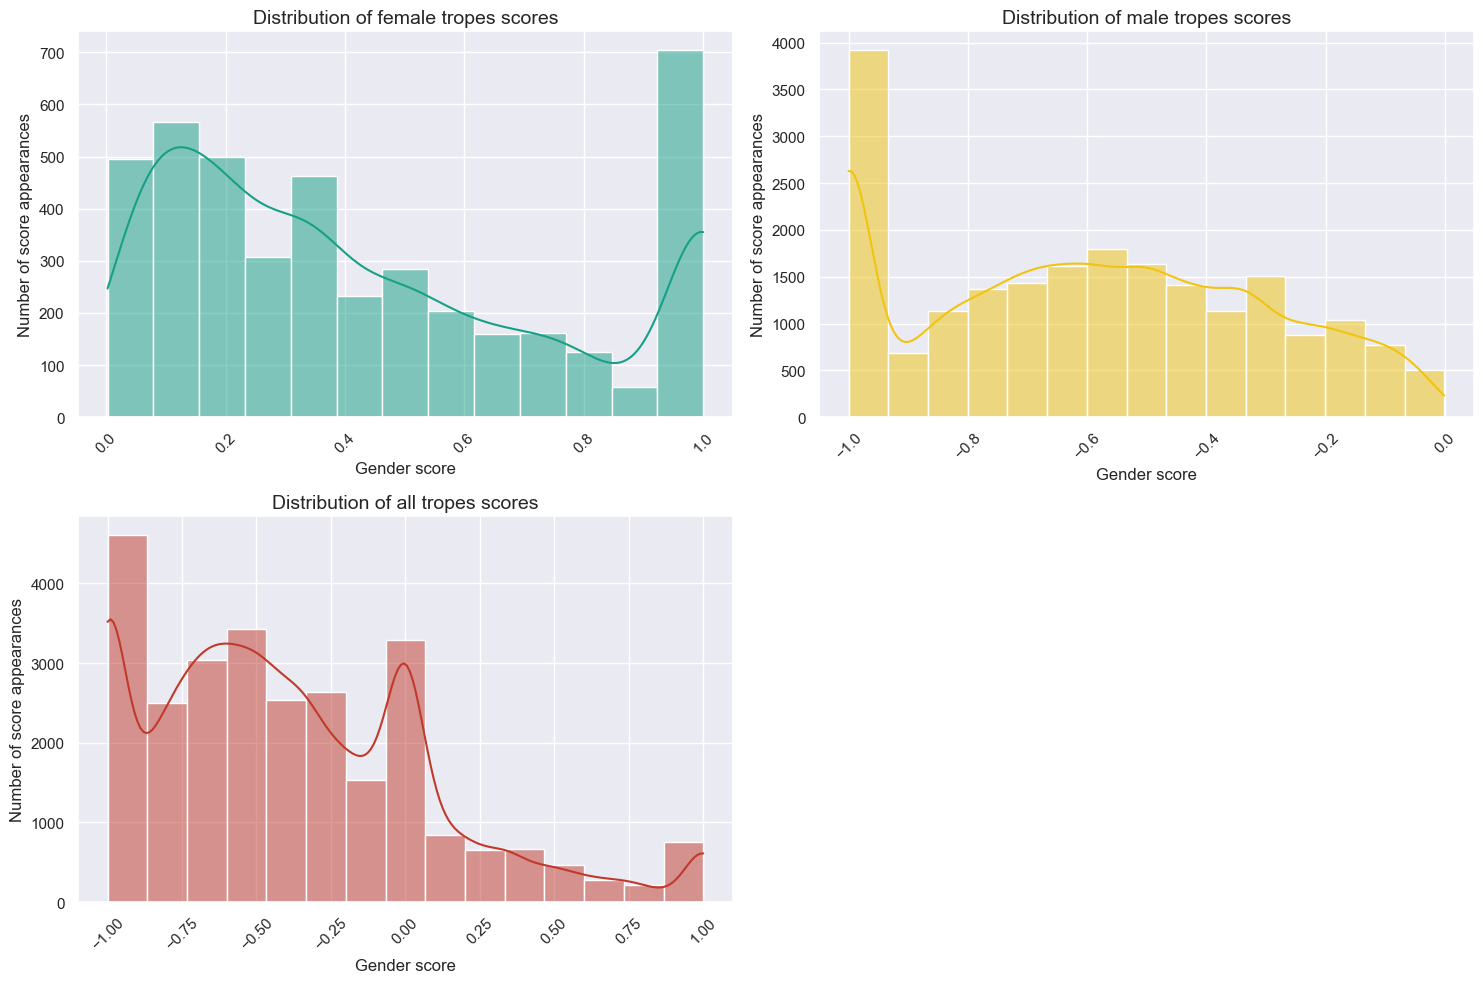

In [155]:

# Let's look at histograms for male and female tropes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# Optimal number of bins
n_female = int(np.log2(female_tropes['Genderedness'].count()) + 1)
n_male = int(np.log2(male_tropes['Genderedness'].count()) + 1)
n_bins = int(np.log2(tropes_wscores['Genderedness'].count()) + 1)

# Plot
sns.set(style="darkgrid")

# Since axs is a 2x2 array, you access its elements with two indices
sns.histplot(data=female_tropes, x="Genderedness", kde=True, color='#16A085', ax=axs[0, 0], bins=n_female)
sns.histplot(data=male_tropes, x="Genderedness", kde=True, color='#F1C40F', ax=axs[0, 1], bins=n_male)
sns.histplot(data=tropes_wscores, x="Genderedness", kde=True, color='#C0392B', ax=axs[1, 0], bins=n_bins)

# Set titles and labels
axs[0, 0].set_title('Distribution of female tropes scores', fontsize=14)
axs[0, 1].set_title('Distribution of male tropes scores', fontsize=14)
axs[1, 0].set_title('Distribution of all tropes scores', fontsize=14)

# Since you have an unused subplot at axs[1, 1], you can hide it
fig.delaxes(axs[1, 1])

# Set labels and ticks
for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:  # Skip the deleted axes
            continue
        axs[i, j].set_xlabel('Gender score', fontsize=12)
        axs[i, j].set_ylabel('Number of score appearances', fontsize=12)
        axs[i, j].tick_params(axis='x', rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

___
**Observations**
First of all, it is evidents we have many more "male" tropes than "female" ones. Could this be a problem? We need to first assess how many of these tropes we can consider and how many movies they are associated with in our main dataset to understand whether this could be a problem. Secondly you see that there's quite a lot of tropes at the extremes. My hypothesis is that these are actually more accurately assessed by the model. Let's see if I'm right. 

**ChatGPT**:
The histograms you've provided show the distribution of gendered trope scores separated into two categories: one for female and one for male. Here are some interpretations:

**Female Tropes Histogram (Green)**
- The histogram shows a significant peak at 1, which indicates a large number of tropes are strongly associated with female characteristics.
- There's a gradual decline in the number of tropes as the gender score decreases from 1 to 0.2, suggesting that fewer tropes have a less strong association with female characteristics.

**Male Tropes Histogram (Yellow)**
- The histogram has a pronounced peak at -1, implying a large number of tropes are strongly associated with male characteristics.
- The distribution of male tropes has multiple smaller peaks, indicating that there are varying levels of male associations among the tropes.

**Comparing Both Histograms**
- The female tropes histogram is characterized by a single, strong peak, suggesting that tropes are either strongly associated with female characteristics or not at all.
- The male tropes histogram is more spread out, indicating a wider variety of male trope associations.
- The visual difference in the distribution shapes indicates that male-associated tropes might have a more diverse range of genderedness scores compared to female-associated tropes.
- We see many more sample points for male than for female tropes

**Implications for Analysis**
- These histograms might reflect biases in the data collection or inherent biases in media representation where male characteristics are more varied or nuanced in tropes, while female characteristics are more likely to be strongly stereotyped.
- The differences in the distribution shapes and the range of scores between male and female tropes might be significant for any further statistical analysis or interpretation regarding gender representation.

It is important to consider the context of how these scores were assigned and the methodology behind the data collection to fully understand the implications of these distributions. The stark contrast between the two histograms could be a point of discussion in your analysis, particularly concerning the representation and diversity of gender portrayal in media tropes.

**Overall plot**
This histogram, with a modified number of bins, provides a different view of the genderedness scores' distribution. Here are some observations:

1. **Central Tendency**: There is a noticeable concentration of scores at the extremes (-1 and 1), suggesting that a significant number of tropes are strongly associated with one gender.

2. **Skewness**: The distribution appears to be slightly skewed towards the negative side (male), implying that there are more male-associated tropes than female-associated ones.

3. **Variability**: Compared to the histograms with more bins, this one with fewer bins shows less variability and detail. However, it still highlights the concentration of scores at the extremes and the center.

4. **Multimodality**: The histogram appears to be multimodal, with multiple peaks indicating that the genderedness scores tend to cluster around certain values.

5. **Outliers**: The extreme values at -1 and 1 stand out significantly, which could be considered as outliers or simply as indicative of a strong gender association.

6. **Neutral Scores**: There's a sizable peak at 0, indicating a considerable number of tropes with neutral genderedness scores.

When choosing the number of bins for a histogram, it's essential to strike a balance between too few and too many. Too few bins can mask important details in the data, while too many can introduce noise and make it difficult to discern the true distribution. The current histogram appears to provide a balanced view, though the choice of the number of bins ultimately depends on the specific questions you're trying to answer with your analysis.
___

____

### Model Performance Assessment

Now, we need to assess the performance of the model. For this we'll use the "Always Female" and "Always Male" lists on the TvTropes website. For this analysis, I will compute the descriptive statistics of the dataset and assume that data above the median in the female dataset and below it in the male dataset are correctly classified as "Always Female" or "Always Male". This is because the median is the most robust measure of central tendency since our distributions showed a lot of outliers. For the performance assessment we will compute a confusion matrix for the two cases:



Based on this we will compute the following metrics:

- Accuracy:
$$
\begin{align*}
\frac{TP+TN}{TP+TN+FP+FN}
\end{align*}
$$
- Precision:
$$
\begin{align*}
\frac{TP}{TP+FP}
\end{align*}
$$
- Recall:
$$
\begin{align*}
\frac{TP}{TP+FN}.
\end{align*}
$$

Where:

- $TP$ is the number of true positives
- $TN$ is the number of true negatives
- $FP$ is the number of false positives
- $FN$ is the number of false negatives

Finally, we utilise Cohen's Kappa to assess the model's performance. This is a measure of inter-rater agreement that takes into account the possibility of the agreement occurring by chance. This will assess the statistical significance of the model's performance.

It is computed as:

$$
\begin{align*}
\kappa = \frac{p_o - p_e}{1-p_e}
\end{align*}
$$

Where:
- $p_o$ is the observed agreement
- $p_e$ is the expected agreement
____

In [156]:
# Make dataframes from the csv files
female_tvtropes = pd.read_csv('./data/female_tvtropes.csv')
male_tvtropes = pd.read_csv('./data/male_tvtropes.csv')

female_tvtropes.head()

,Trope;;;;;;
0,Action Girl;;;;;;
1,Action Girlfriend;;;;;;
2,Action Mom;;;;;;
3,All Girls Like Ponies;;;;;;
4,All Periods Are PMS;;;;;;


In [157]:
def camel_case(s):
    """Function that converts a string to camel case (LikeThis)"""

    # remove punctuation
    s = sub(r"(_|-)+", " ", s).title().replace(" ", "")

    # remove ;
    s = s.replace(';', '')
    
    # Join the string
    return ''.join([s[0], s[1:]])

In [158]:
# Make everything camel case like our other dataframe
female_tvtropes['Trope'] = female_tvtropes['Trope;;;;;;'].apply(camel_case)
female_tvtropes = female_tvtropes.drop(columns = 'Trope;;;;;;')

# Print result
female_tvtropes.head()

,Trope
0,ActionGirl
1,ActionGirlfriend
2,ActionMom
3,AllGirlsLikePonies
4,AllPeriodsArePms


In [159]:
# Same for males
male_tvtropes['Trope'] = male_tvtropes['Trope;;;;;;'].apply(camel_case)
male_tvtropes = male_tvtropes.drop(columns = 'Trope;;;;;;')

# Print result
male_tvtropes.head()

,Trope
0,AbsentMindedProfessor
1,AccidentalPervert
2,AccidentalPornomancer
3,ActionDad
4,ActionHeroBabysitter


____
**Note**

The performance assessment can only happen with the tropes that exist in the "Always Female" and "Always Male" lists. So, from here on we'll only use these tropes to assess the model's performance. We do this by inner joining the TvTropes "Always" lists (`female_tvtropes`, `male_tvtropes`) with the dataset containing our predictions (i.e. `tropes_wscores`) and creating two new dataframes: `female_scores`, `male_scores`

___

In [160]:
# Now, merge the prediction and expectation dataframes
female_scores = female_tvtropes.merge(tropes_wscores, on = 'Trope')

# Only keep the relevant columns
female_scores.drop(columns = ['Example',
                              'Movie Title',	
                              'Movie ID',	
                              'Trope ID',	
                              'Processed Examples',	
                              'MaleCount',	
                              'FemaleCount']);

In [162]:
# Same for males
male_scores = male_tvtropes.merge(tropes_wscores, on = 'Trope')

# Only keep the relevant columns
male_scores.drop(columns = ['Example',
                              'Movie Title',	
                              'Movie ID',	
                              'Trope ID',	
                              'Processed Examples',	
                              'MaleCount',	
                              'FemaleCount']);




___
How to compare whether scores agree? I obviously need to set a threshold above or below which a trope is set as clearly male or female. Ok, we can analyse the distributions of the tropes and see if there's a natural split in the data for example. 
___

In [163]:
female_tropes.describe()

,MaleCount,FemaleCount,Genderedness
count,4262.000000,4262.000000,4262.000000
mean,20.562647,38.242844,0.437994
std,42.003668,74.388408,0.326955
min,0.000000,1.000000,0.001965
25%,1.000000,5.000000,0.156496
50%,7.000000,15.000000,0.333333
75%,21.000000,40.000000,0.684211
max,539.000000,1590.000000,1.000000


In [164]:
male_tropes.describe()

,MaleCount,FemaleCount,Genderedness
count,20822.000000,20822.000000,20822.000000
mean,63.490395,21.518874,-0.596509
std,157.707714,68.504272,0.285477
min,1.000000,0.000000,-1.000000
25%,9.000000,1.000000,-0.833333
50%,24.000000,6.000000,-0.600000
75%,61.000000,20.000000,-0.372881
max,8538.000000,5523.000000,-0.001513


___

We'll use the median to split the data. Let's plot a boxplot to visualise the results
___

/var/folders/1p/qz5cmf3n1636qzdrz0xqmbnw0000gn/T/ipykernel_14222/3456334561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_tropes['Gender'] = 'Female'
/var/folders/1p/qz5cmf3n1636qzdrz0xqmbnw0000gn/T/ipykernel_14222/3456334561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_tropes['Gender'] = 'Male'


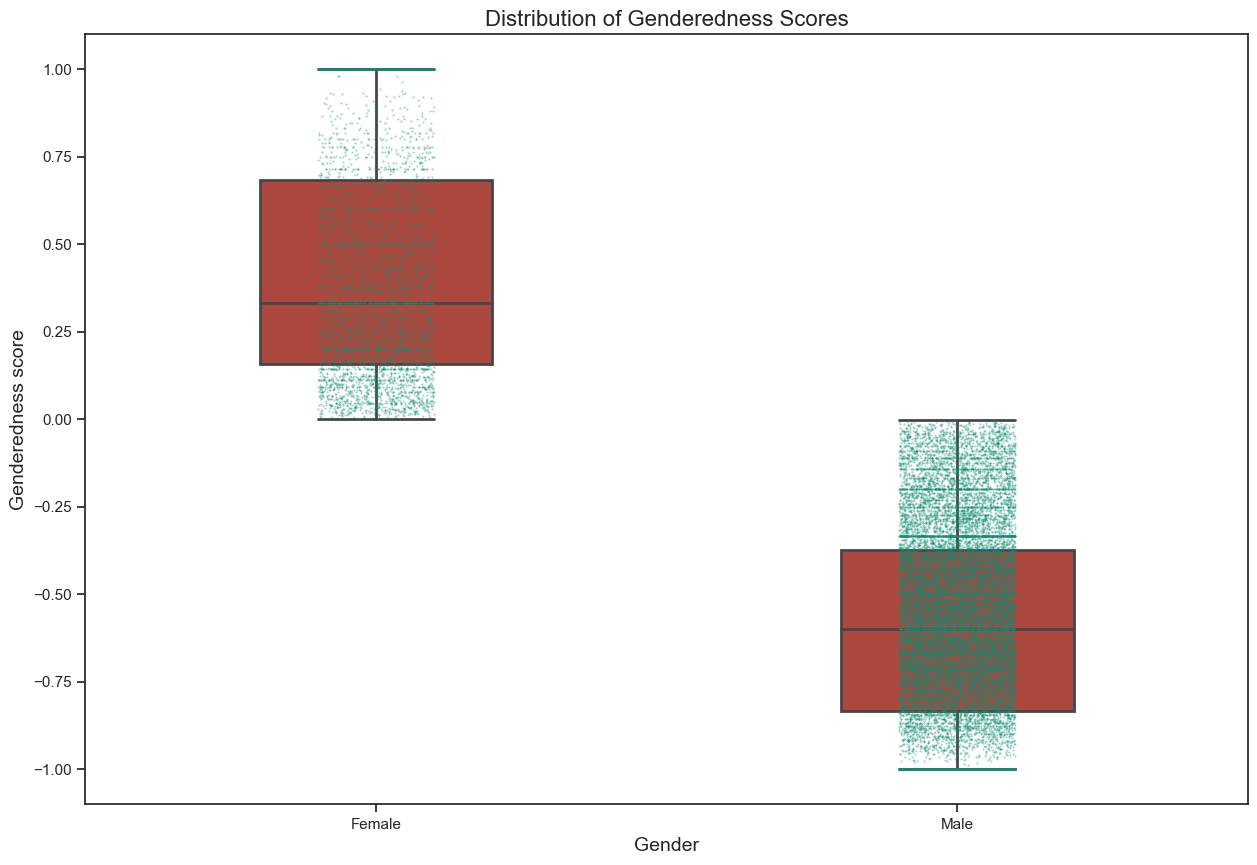

In [185]:
# Create a new column in each DataFrame to indicate the gender category
female_tropes['Gender'] = 'Female'
male_tropes['Gender'] = 'Male'

# Combine the two DataFrames
combined_tropes = pd.concat([female_tropes, male_tropes])

# Create the boxplot

# Change some of seaborn's style settings with `sns.set()`
sns.set(
        style="ticks",                   # The 'ticks' style
        rc={"figure.figsize": (15, 10),      # width = 6, height = 9
            "figure.facecolor": "white",  # Figure colour
            "axes.facecolor": "white"})  # Axes colour
# Box plot
b = sns.boxplot(data = combined_tropes,           
                    x = "Gender",       # x axis column from data
                    y = "Genderedness",       # y axis column from data
                    width = 0.4,        # The width of the boxes
                    color='#C0392B',  # Box colour
                    linewidth = 2,      # Thickness of the box lines
                    showfliers = False)  # Sop showing the fliers
# Strip plot
b = sns.stripplot(data = combined_tropes,           
                    x = "Gender",       # x axis column from data
                    y = "Genderedness",     # y axis column from data
                      color = "#138D75", # Colours the dots
                      linewidth = 0,     # Dot outline width
                      alpha = 0.4,
                      s = 1.5)       # Makes them transparent

b.set_ylabel("Genderedness score", fontsize = 14)
# Set the x axis label and font size
b.set_xlabel("Gender", fontsize = 14)
# Set the plot title and font size
b.set_title("Distribution of Genderedness Scores", fontsize = 16)
# Remove axis spines
# sns.despine(offset = 5, trim = True)
# Show the figure
b.get_figure();

____

Ok, so. We'll say that whatever's above the median of the female distribution (0.33) is clearly female and scores below the median of the male distribution (-0.6) is clearly male. Based on this, we'll check to what extent our scoring system agrees with the always female - always male dataframes we have.
____

In [186]:
female_tvtropes.head()

,Trope
0,ActionGirl
1,ActionGirlfriend
2,ActionMom
3,AllGirlsLikePonies
4,AllPeriodsArePms


In [187]:
# Add columns in the TvTropes and assessment dataframes with "female" , "male" labels
female_tvtropes['Gender'] = 'Female'
male_tvtropes['Gender'] = 'Male'

In [188]:
# Drop the gender column we previously added for the boxplot
female_tropes = female_tropes.drop(columns = 'Gender')


____
Now, let's see what's happening within each quartile. We'll see what percentage of the always female and always male expectations lie within each quartile. This will give us an idea of how well the model is performing and where we should split the data to get the best results and analyse performance accordingly

____

In [194]:
# First identify the quantiles
q = pd.DataFrame(female_tropes['Genderedness'].quantile([0.00, 0.25, 0.50, 0.75, 1.00]))
qm = pd.DataFrame(male_tropes['Genderedness'].quantile([0.00, 0.25, 0.50, 0.75, 1.00]))

col = 'Genderedness'

# Define conditions to split data based on quartiles
conditions_q = [(female_tropes[col]>=q[col][0.00]) & (female_tropes[col]<q[col][0.25]),
                (female_tropes[col]>=q[col][0.25]) & (female_tropes[col]<q[col][0.50]),
                (female_tropes[col]>=q[col][0.50]) & (female_tropes[col]<q[col][0.75]),
                (female_tropes[col]>=q[col][0.75]) & (female_tropes[col]<q[col][1.00])]

conditions_qm = [(male_tropes[col]>=qm[col][0.00]) & (male_tropes[col]<qm[col][0.25]),
                (male_tropes[col]>=qm[col][0.25]) & (male_tropes[col]<qm[col][0.50]),
                (male_tropes[col]>=qm[col][0.50]) & (male_tropes[col]<qm[col][0.75]),
                (male_tropes[col]>=qm[col][0.75]) & (male_tropes[col]<qm[col][1.00])]

values_q = ['Q1', 'Q2', 'Q3', 'Q4']
values_qm = values_q

# Create a new column with the quartile information for the scores
female_tropes['Quartile'] = np.select(conditions_q, values_q)
male_tropes['Quartile'] = np.select(conditions_qm, values_qm)

# Check result
female_tropes.head()

/var/folders/1p/qz5cmf3n1636qzdrz0xqmbnw0000gn/T/ipykernel_14222/3715885950.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_tropes['Quartile'] = np.select(conditions_qm, values_qm)


,Trope,Example,Movie Title,Movie ID,Trope ID,Processed Examples,MaleCount,FemaleCount,Genderedness,Assessed Gender,Quartile
11,ACupAngst,Jane is looking up breast augmentation on the...,"['AmericanBeauty', 'AnneFrankTheWholeStory', '...","['f604', 'f784', 'f1112', 'f1851', 'f2819', 'f...",t00222,"['jane', 'is', 'looking', 'up', 'breast', 'aug...",13,90,0.747573,Female,Q4
12,ADarkerMe,Nina's 's 'Black Swan' persona. Much of the f...,"['BlackSwan', 'MirrorMask', 'MirrorMask', 'The...","['f1547', 'f7954', 'f7954', 'f12048', 'f14015']",t00280,"['nina', 'swan', 'persona', 'much', 'of', 'the...",1,5,0.666667,Female,Q3
43,AGoodNameForARockBand,"British rapper, Bugzy Malone named himself af...","['BugsyMalone', 'Closer', 'CyberSeductionHisSe...","['f1976', 'f2540', 'f2891', 'f2891', 'f3382', ...",t00439,"['british', 'rapper', 'bugzy', 'malone', 'name...",21,22,0.023256,Ambiguous,Q1
47,AHeadAtEachEnd,One of the cobbled-together undead from the s...,"['BrideOfReAnimator', 'DoctorDolittle', 'Docto...","['f1881', 'f3462', 'f3462', 'f3582', 'f3711', ...",t00445,"['one', 'of', 'the', 'undead', 'from', 'the', ...",2,5,0.428571,Female,Q3
58,AKA47,GoldenEye (1997) (and most other James Bond g...,"['AViewToAKill', 'Aliens', 'CasinoRoyale2006',...","['f272', 'f493', 'f2238', 'f3942', 'f3942', 'f...",t00473,"['goldeneye', 'and', 'most', 'other', 'james',...",7,14,0.333333,Female,Q3


In [196]:
# Compare amount of tropes from list in each quartile
female_tvtropes_list = list(female_tvtropes['Trope'])
male_tvtropes_list = list(male_tvtropes['Trope'])

In [197]:
# Function to count number of tropes in each quartile 
def count_q(df, base_list = female_tvtropes_list):
    my_list = list(df)
    count_q = 0
    for i in base_list:
        for j in my_list:
            if i == j :
                count_q += 1
    return count_q

In [202]:
for quartile in ['Q1', 'Q2', 'Q3', 'Q4']:
    percentage = (count_q(female_tropes[female_tropes['Quartile'] == quartile]['Trope'], female_tvtropes_list)/len(female_tvtropes_list)) * 100
    print(f"Percentage of always female tropes in {quartile} of predictions: {percentage:.2f}")


Percentage of always female tropes in Q1 of predictions: 5.70
Percentage of always female tropes in Q2 of predictions: 8.11
Percentage of always female tropes in Q3 of predictions: 32.02
Percentage of always female tropes in Q4 of predictions: 21.27


In [203]:
for quartile in ['Q1', 'Q2', 'Q3', 'Q4']:
    percentage = (count_q(male_tropes[male_tropes['Quartile'] == quartile]['Trope'], male_tvtropes_list)/len(male_tvtropes_list)) * 100
    print(f"Percentage of always male tropes in {quartile} of predictions: {percentage:.2f}")


Percentage of always male tropes in Q1 of predictions: 25.30
Percentage of always male tropes in Q2 of predictions: 24.51
Percentage of always male tropes in Q3 of predictions: 13.83
Percentage of always male tropes in Q4 of predictions: 18.18


___
We can see that about 50% of the clearly gendered tropes lie above and below the median of the female and male dataframes respectively. So, we'll use the median to split the data saying that:
- the model's assessment is "always female" when the score is above the median for the list of tropes we have in the "Always Female" expactations
- the model's assessment is "always male" when the score is below the median for the list of tropes we have in the "Always Male" expactations

Note that we obviously need to discretize our scores for this to work. So, what we do is say that if the classifier has assessed a trope as always female (i.e. above the median) this takes a score of 1. Respectively for males it takes a score of -1.
____

In [204]:
# Ok let's start again. Take my tropes dataframe again
tropes_wscores.head()

,Trope,Example,Movie Title,Movie ID,Trope ID,Processed Examples,MaleCount,FemaleCount,Genderedness
0,ABNegative,"In Andhadhun, Dr. Swami says that it has been...","['Andhadhun', 'BloodWork', 'BloodWork', 'Bruce...","['f730', 'f1657', 'f1657', 'f1950', 'f1950', '...",t00028,"['in', 'andhadhun', 'swami', 'say', 'that', 'i...",40,24,-0.250000
1,ABPositive,"In Andhadhun, Dr. Swami says that it has been...","['Andhadhun', 'BloodWork', 'BruceAlmighty', 'E...","['f730', 'f1657', 'f1950', 'f3756', 'f4789', '...",t30575,"['in', 'andhadhun', 'swami', 'say', 'that', 'i...",32,22,-0.185185
2,ABirthdayNotABreak,Bruce Wayne has a party on his birthday. Unfo...,"['BatmanBegins', 'BatmanBegins', 'BigGame', 'G...","['f1197', 'f1197', 'f1429', 'f4931', 'f5266', ...",t00025,"['bruce', 'wayne', 'ha', 'a', 'party', 'on', '...",28,19,-0.191489
3,ABloodyMess,Inverted in Bloody Birthday during a scene wh...,"['BloodyBirthday', 'CarryOnBehind', 'CloudAtla...","['f1675', 'f2191', 'f2544', 'f2717', 'f2717', ...",t00027,"['inverted', 'in', 'bloody', 'birthday', 'duri...",44,28,-0.222222
4,ABoyAGirlAndABabyFamily,The Cooper Family from Alexander and the Terr...,['AlexanderAndTheTerribleHorribleNoGoodVeryBad...,"['f448', 'f685', 'f5662', 'f5663', 'f11938', '...",t00038,"['the', 'cooper', 'family', 'from', 'alexander...",2,2,0.000000


In [207]:
# Drop columns unnecessary for the confusion matrix and make copy of dataframe
tropes_wscores_ = tropes_wscores.drop(columns = ['Movie Title', 'Movie ID',
                                              'Trope ID', 'Processed Examples', 'MaleCount',
                                              'FemaleCount', 'Example'])
tropes_wscores_.head()

,Trope,Genderedness
0,ABNegative,-0.250000
1,ABPositive,-0.185185
2,ABirthdayNotABreak,-0.191489
3,ABloodyMess,-0.222222
4,ABoyAGirlAndABabyFamily,0.000000


In [209]:
# Conditions
cond_again = [
    (tropes_wscores_['Genderedness']>=q['Genderedness'][0.50]),
    (tropes_wscores_['Genderedness']<=qm['Genderedness'][0.50]) # Values that should be classified as 1
]

# When we're clearly female the binary score is 1. When we're clearly male the binary score is -1
val = [1, -1]

# Apply conditions and values, with 0 as the default value for those not meeting any condition
tropes_wscores_['Classification'] = np.select(cond_again, val, default=5)


In [210]:
# Assign 1 as score to our "Always Female" expected tropes
female_scores_ = pd.DataFrame(female_scores['Trope'])
female_scores_['Expectation'] = 1

In [211]:
# Assign -1 to our "Always Male" expected tropes
male_scores_ = pd.DataFrame(male_scores['Trope'])
male_scores_['Expectation'] = -1

In [212]:
# Put the known scores together
total_scores = pd.concat([female_scores_, male_scores_])
total_scores.head()

,Trope,Expectation
0,ActionGirl,1
1,ActionGirlfriend,1
2,ActionMom,1
3,AllGirlsLikePonies,1
4,AllWomenAreLustful,1


In [213]:
# Merge predictions and expectations
pred_expect_merge = pd.merge(tropes_wscores_, total_scores, how = 'left', on = 'Trope')
pred_expect_merge.head()

,Trope,Genderedness,Classification,Expectation
0,ABNegative,-0.250000,5,NaN
1,ABPositive,-0.185185,5,NaN
2,ABirthdayNotABreak,-0.191489,5,NaN
3,ABloodyMess,-0.222222,5,NaN
4,ABoyAGirlAndABabyFamily,0.000000,5,NaN


In [215]:
# Drop the rows with NaN values in expectation column since we only care about tropes we have known scores for
pred_expect_merge = pred_expect_merge.dropna(subset=['Expectation'])
pred_expect_merge.head()

,Trope,Genderedness,Classification,Expectation
28,AFatherToHisMen,-0.896296,-1,-1.0
60,ALadyOnEachArm,-0.309524,5,-1.0
176,AbsentMindedProfessor,-0.779817,-1,-1.0
259,AccidentalPervert,-0.148289,5,-1.0
260,AccidentalPornomancer,0.000000,5,-1.0


____

### Accuracy
The number of samples correctly classified out of all the samples present in the test set.

$$\begin{align*}Accuracy = \frac{TP + TN}{TP + TN + FP + FN}\end{align*}$$

We'll do this from both the female and male perspective
_____

In [216]:
# where we agree that a trope is female
TP_f = pred_expect_merge[(pred_expect_merge['Classification'] == 1) & (pred_expect_merge['Expectation'] == 1)].count()[0]
TP_m = pred_expect_merge[(pred_expect_merge['Classification'] == -1) & (pred_expect_merge['Expectation'] == -1)].count()[0]

In [217]:
# where we agree that a trope is male
TN_f = pred_expect_merge[(pred_expect_merge['Classification'] == -1) & (pred_expect_merge['Expectation'] == -1)].count()[0]
TN_m = pred_expect_merge[(pred_expect_merge['Classification'] == 1) & (pred_expect_merge['Expectation'] == 1)].count()[0]

In [218]:
# where i say it's female and the model says it's not
FP_f = pred_expect_merge[(pred_expect_merge['Classification'] == 1) & (pred_expect_merge['Expectation'] == -1)].count()[0]
FP_m = pred_expect_merge[(pred_expect_merge['Classification'] == -1) & (pred_expect_merge['Expectation'] == 1)].count()[0]


In [219]:
# where i say it's male or something else and the model says it's female
FN_f1 = pred_expect_merge[(pred_expect_merge['Classification'] == -1) & (pred_expect_merge['Expectation'] == 1)].count()[0]
FN_f2 = pred_expect_merge[ (pred_expect_merge['Classification'] == 5) & (pred_expect_merge['Expectation'] == 1)].count()[0]
FN_m1 = pred_expect_merge[(pred_expect_merge['Classification'] == 1) & (pred_expect_merge['Expectation'] == -1)].count()[0]
FN_m2 = pred_expect_merge[(pred_expect_merge['Classification'] == 2) & (pred_expect_merge['Expectation'] == -1)].count()[0]
FN_m = FN_m1 + FN_m2
FN_f = FN_f1 + FN_f2


In [220]:
accuracy_f = (TP_f + TN_f)/(TP_f + TN_f + FP_f + FN_f)
precision_f = TP_f/(TP_f + FP_f)
recall_f = TP_f/(TP_f + FN_f)


In [221]:
print(f"The accuracy of the model in correctly predicting female tropes is: {accuracy_f*100:.2f}%")
print(f"The precision of the model in correctly predicting female tropes is: {precision_f*100:.2f}%")
print(f"The recall of the model in correctly predicting female tropes is: {recall_f*100:.2f}%")

The accuracy of the model in correctly predicting female tropes is: 78.23%
The precision of the model in correctly predicting female tropes is: 98.93%
The recall of the model in correctly predicting female tropes is: 71.58%


In [222]:
accuracy_m = (TP_m + TN_m)/(TP_m + TN_m + FP_m + FN_m)
precision_m = TP_m/(TP_m + FP_m)
recall_m = TP_m/(TP_m + FN_m)


In [223]:
print(f"The accuracy of the model in correctly predicting male tropes is: {accuracy_m*100:.2f}% ")
print(f"The precision of the model in correctly predicting male tropes is: {precision_m*100:.2f}% ")
print(f"The recall of the model in correctly predicting male tropes is: {recall_m*100:.2f}% ")


The accuracy of the model in correctly predicting male tropes is: 98.07% 
The precision of the model in correctly predicting male tropes is: 96.27% 
The recall of the model in correctly predicting male tropes is: 97.73% 


___

We notice the the accuracy of our predictions is much better for male than for female tropes. This could be due to an imbalance in the data. We need to consider this further if we are to use this model. 
We now need to test the statistical significance of the agreement between the model and the expected values. We do this using Cohen's kappa. We compute this both for the overall predictions and the individual male and female ones.
___

In [225]:
# Cohen's kappa to measure inter-rater agreement
cohen = pred_expect_merge.dropna(subset=['Expectation'])

In [226]:
# Calculate Cohen's Kappa
kappa = cohen_kappa_score(cohen.loc[cohen['Classification'] == 1], cohen['Expectation'])

print(f'Cohen\'s Kappa: {kappa:.2f}')

Cohen's Kappa: 0.46


___

The Kappa statistic suggests moderated agreement between the two raters (i.e. the model and the TVTropes database).
___

Notes:
- We don't know how well the model performs with implicitly gendered tropes.

